# ASE - Setup the Silicon System

In [9]:
%matplotlib notebook
import matplotlib.pyplot as plt
from ase.calculators.lammpslib import LAMMPSlib, write_lammps_data
from ase.lattice.cubic import Diamond
from ase.visualize import view


header = ['units real',
      'atom_style molecular',
      'pair_style zero 10.0',
      'bond_style harmonic',
      'angle_style harmonic']

cmds = ["pair_coeff * * ",
    "bond_coeff * 100.0 2.351",
    "angle_coeff * 100.0 109.47",
    "fix 1 all nve"]

lat_dims=(2,2,2)
atoms = Diamond( symbol='Si', size=lat_dims )
print(atoms.get_positions())

# parallel via mpi4py
try:
    from mpi4py import MPI
    me = MPI.COMM_WORLD.Get_rank()
    nprocs = MPI.COMM_WORLD.Get_size()
except:
    me = 0

# Set LAMMPS as Calculator
calc = LAMMPSlib(lmpcmds=cmds,
               lammps_header=header,
               atom_types={'Si': 1},
               log_file='test.log', keep_alive=True)

atoms.set_calculator(calc)

write_lammps_data('silicon.data',
              atoms,
              {'Si': 1},
              cutoff=2.351,
              bond_types=[(14,14)],
              angle_types=[(14,14,14)],
              units='real')


[[ 0.      0.      0.    ]
 [ 1.3575  1.3575  1.3575]
 [ 2.715   2.715   0.    ]
 [ 4.0725  4.0725  1.3575]
 [ 2.715   0.      2.715 ]
 [ 4.0725  1.3575  4.0725]
 [ 0.      2.715   2.715 ]
 [ 1.3575  4.0725  4.0725]
 [ 5.43    0.      0.    ]
 [ 6.7875  1.3575  1.3575]
 [ 8.145   2.715   0.    ]
 [ 9.5025  4.0725  1.3575]
 [ 8.145   0.      2.715 ]
 [ 9.5025  1.3575  4.0725]
 [ 5.43    2.715   2.715 ]
 [ 6.7875  4.0725  4.0725]
 [ 0.      5.43    0.    ]
 [ 1.3575  6.7875  1.3575]
 [ 2.715   8.145   0.    ]
 [ 4.0725  9.5025  1.3575]
 [ 2.715   5.43    2.715 ]
 [ 4.0725  6.7875  4.0725]
 [ 0.      8.145   2.715 ]
 [ 1.3575  9.5025  4.0725]
 [ 5.43    5.43    0.    ]
 [ 6.7875  6.7875  1.3575]
 [ 8.145   8.145   0.    ]
 [ 9.5025  9.5025  1.3575]
 [ 8.145   5.43    2.715 ]
 [ 9.5025  6.7875  4.0725]
 [ 5.43    8.145   2.715 ]
 [ 6.7875  9.5025  4.0725]
 [ 0.      0.      5.43  ]
 [ 1.3575  1.3575  6.7875]
 [ 2.715   2.715   5.43  ]
 [ 4.0725  4.0725  6.7875]
 [ 2.715   0.      8.145 ]
 

# PyLammps - Do an initial setup and run of the silicon

In [1]:
#--------------------------------------------------#
# PyLammps
#--------------------------------------------------#

from lammps import IPyLammps

L = IPyLammps()
L.units('real')
L.dimension(3)
L.boundary('p p p')
L.atom_style('full')
L.read_data("./silicon.data")
L.pair_style('zero', 10.0)
L.bond_style('harmonic')
L.angle_style('harmonic')

L.pair_coeff('*', '*')
L.bond_coeff('*',100.0,2.351)
L.angle_coeff('*',100.0,109.47)

L.neighbor(5.0,'bin')
L.neigh_modify('delay 1')
L.fix('1 all nve')
L.dump('1 all atom 100 dump.silicon.lammpstrj')

L.velocity('all create 300.0 2341')

L.command('thermo_style custom step time etotal pe ke')
L.thermo(100)

L.command('run 5000')
#MPI.Finalize()


LAMMPS output is captured by PyLammps wrapper


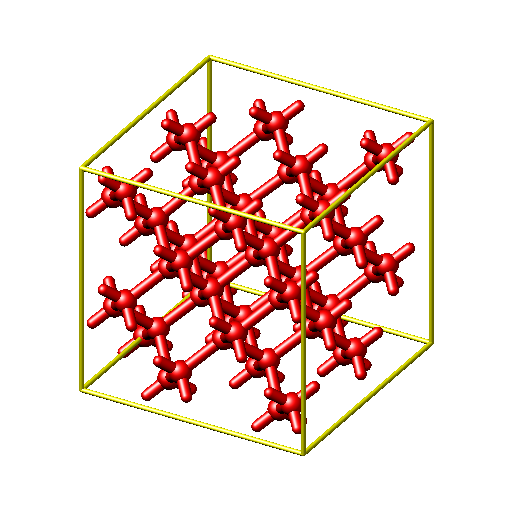

In [2]:
L.image()

## Create groups for the bond swapping atoms 
Molecular topology: 1-2-3-4

In [3]:
A=43
B=16
C=57
D=22

A=str(A)
B=str(B)
C=str(C)
D=str(D)

L.command('group A id '+A)
L.command('group B id '+B)
L.command('group C id '+C)
L.command('group D id '+D)

L.command('group ABCD union A B C D')

L.command('group AB union A B')
L.command('group BC union B C')
L.command('group CD union C D')

L.command('group AC union A C')
L.command('group BD union B D')

L.command('group ABC union A B C')
L.command('group BCD union B C D')

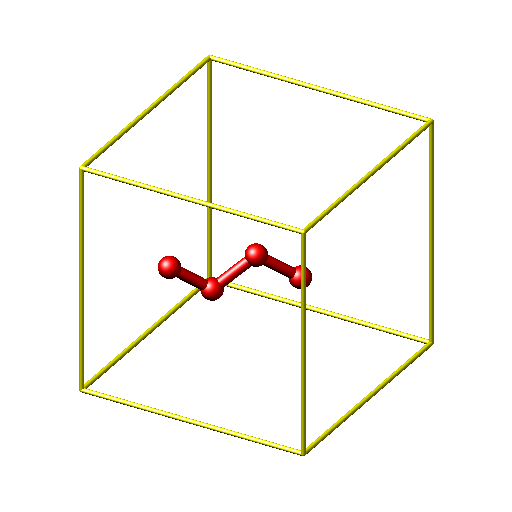

In [4]:
L.image(group='ABCD')

## Delete bonds from the group  
multi => bond, angle, dihedral, and improper    
remove => remove from data structure of atoms (not just turn off bond, angle, etc.)
any => the interaction removed does not have to be just between atoms in the group   
    
#### ISSUES
If we do `(AB, BD)mutli remove any`,the BC are also deleted  
If we do `(AB, BD) bond remove any`, again the BC bond is also deleted    
If we do `(AB, BD) angle remove any`, then the angles that include just A are deleted thus instead of 5 angles being delted, ~30 are deleted (excess)   
If we do `(B,C) angle * remove any`, then the angles for B outside this dihedral are also deleted => instead of 5, ~18 bonds are deleted.

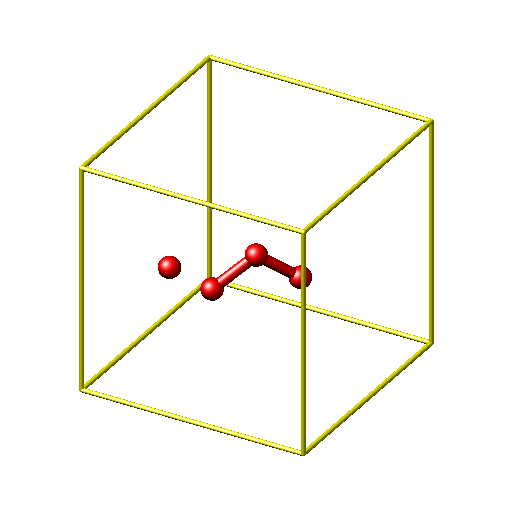

In [5]:

L.command('delete_bonds AB bond * remove')
#L.command('delete_bonds CD bond * remove')
L.image(group='ABCD')


## Create bonds  
##### NOTE: Must do run (w/ pre yes which is default) to have the bonds re-created)

Neighbor list info ...
  update every 1 steps, delay 1 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 15
  ghost atom cutoff = 15
  binsize = 7.5, bins = 2 2 2
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair zero, half, perpetual
      pair build: half/bin/newton/tri
      stencil: half/bin/3d/newton/tri
      bin: standard
Setting up Verlet run ...
  Unit style    : real
  Current step  : 5000
  Time step     : 1
Memory usage per processor = 11.5325 Mbytes
Step Time TotEng PotEng KinEng 
    5000         5000    56.286025    22.765275     33.52075 
Loop time of 9.53674e-07 on 1 procs for 0 steps with 64 atoms

0.0% CPU use with 1 MPI tasks x no OpenMP threads

MPI task timing breakdown:
Section |  min time  |  avg time  |  max time  |%varavg| %total
---------------------------------------------------------------
Pair    | 0          | 0          | 0          |   0.0 |  0.00
Bond    | 0          | 0          | 0         

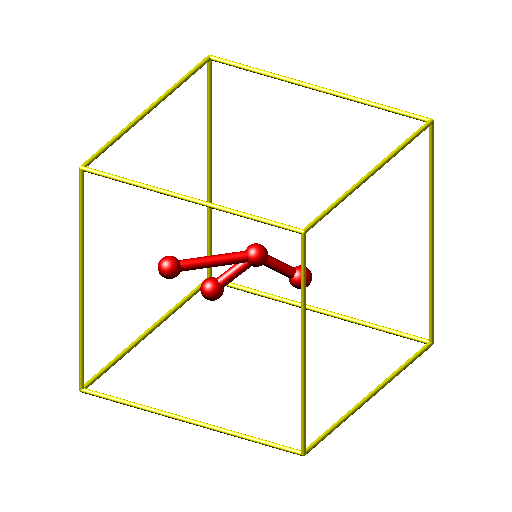

In [7]:
L.run(0)
L.run(0)
print L.atoms[42].id, L.atoms[42].position
print L.atoms[56].id, L.atoms[56].position
L.command('create_bonds A C 1 1.0 7.5')
#L.command('create_bonds B D 1 1.0 7.5')
L.image(group='ABCD')
#L.command('create_bonds B D 1 1.0 4.0')

In [7]:
import math
iatom = L.atoms[42].position
jatom = L.atoms[56].position
delx = iatom[0] -jatom[0]
dely = iatom[1] -jatom[1]
delz = iatom[2] -jatom[2]
rsq = delx*delx + dely*dely + delz*delz
print rsq, math.sqrt(rsq)

14.4997352883 3.80785179443
